<a href="https://colab.research.google.com/github/iking919/Projects-in-AI-and-ML/blob/hw2/ProjectsInMLandAI_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projects in ML & AI HW2 - Izaak King

In this homework, the same problem as in homework 1 will be solved using different machine learning techniques. Specifically, we will use a [Heart Disease dataset](https://www.kaggle.com/datasets/neurocipher/heartdisease) found on Kaggle to predict if heart disease is present in patients. In contrast to the Logistic Regression approach, we will use three models on this dataset, inclusing a Single Decision Tree, one Bagging-based ensemble method and one Boosting-based ensemble method.

This dataset will be downloaded locally and imported from my google drive.

Setup


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from numpy import mean, std
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from scipy.stats import ttest_rel

The same preprocessing pipeline from Homework 1 is reused to ensure a fair comparison between modeling approaches. Categorical features are one-hot encoded. Additionally, highly correlated clinical variables (Age, Blood Pressure, Cholesterol, and Maximum Heart Rate) are combined into a single standardized Cardiac_Score feature to mitigate multicollinearity. Exploratory data analysis was addressed in Homework 1 and are omitted here.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Projects_In_AI_and_ML/HW1_Data/Heart_Disease_Prediction.csv')

# Create a numeric version of disease diagnosis
df['Heart Disease'] = df['Heart Disease'].map({'Presence': 1, 'Absence': 0})

# One-hot encode categorical variables
categorical_cols = ['Chest pain type', 'EKG results', 'Number of vessels fluro']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Create Cardiac Score
high_corr_features = ['Age', 'BP', 'Cholesterol', 'Max HR']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[high_corr_features])

df['Cardiac_Score'] = scaled_features.sum(axis=1)
df.drop(columns=high_corr_features, inplace=True)

# Split features/target
X = df.drop('Heart Disease', axis=1)
y = df['Heart Disease']

Mounted at /content/drive


## **Task 1: Decision Tree Classifier Implementation**


We begin by implementing a single decision tree classifier using the scikit-learn tree package. To maintain consistency with Homework 1, the same stratified train-test split is used. Stratified k-fold cross-validation will be used in Task 2 for comparative evaluation. This task focuses on visualizing how decision tree depth and complexity vary with different parameter settings, as well as performing sensitivity analysis to evaluate the impact of input features on the model's decision boundary.    
     
$ \\ $     

We will intialize four different trees, using max depths of 2, 5, 10 and None.

In [ ]:
# Stratified train-test split (same as HW1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Define tree depths
tree_depths = [2, 5, 10, None]

# Dictionary to store trained trees
trees = {}

for depth in tree_depths:
    # Initialize Decision Tree with current max_depth
    dt = DecisionTreeClassifier(
      max_depth=depth,
      random_state=42
    )

    # Train the decision tree
    dt.fit(X_train, y_train)
    trees[depth] = dt

    # Predict on test set
    y_pred = dt.predict(X_test)

    # Evaluate model
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)

    print(f"Decision Tree (max_depth={depth}): "
          f"Accuracy = {acc:.3f}, Precision = {prec:.3f}")

Decision Tree (max_depth=2): Accuracy = 0.796, Precision = 0.810
Decision Tree (max_depth=5): Accuracy = 0.796, Precision = 0.783
Decision Tree (max_depth=10): Accuracy = 0.759, Precision = 0.720
Decision Tree (max_depth=None): Accuracy = 0.759, Precision = 0.720


### Visualizing Decision Tree Structure
We use Matplotlib to plot each decision tree of various depths, examining the depth and complexity of each tree, as we use max depth parameter settings of 2, 5, 10 and None.

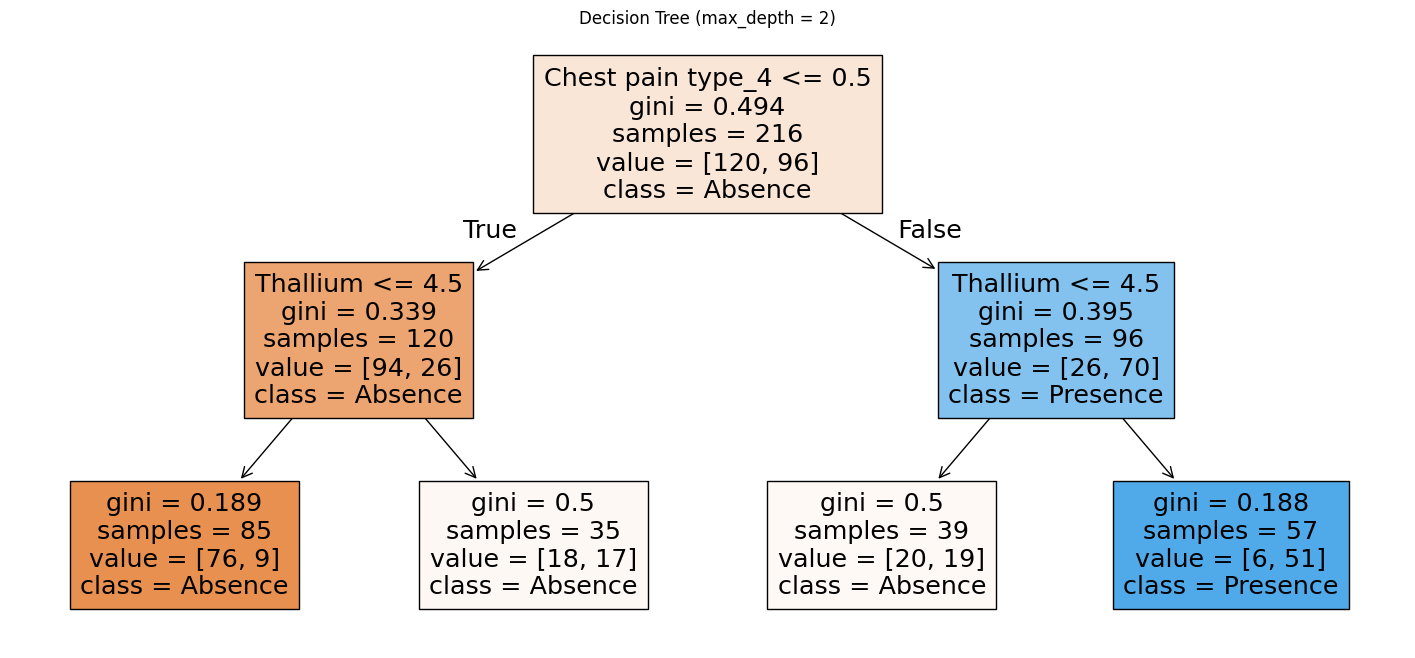

In [ ]:
plt.figure(figsize=(18, 8))
plot_tree(
    trees[2],
    feature_names=X.columns,
    class_names=['Absence', 'Presence'],
    filled=True
)
plt.title("Decision Tree (max_depth = 2)")
plt.show()

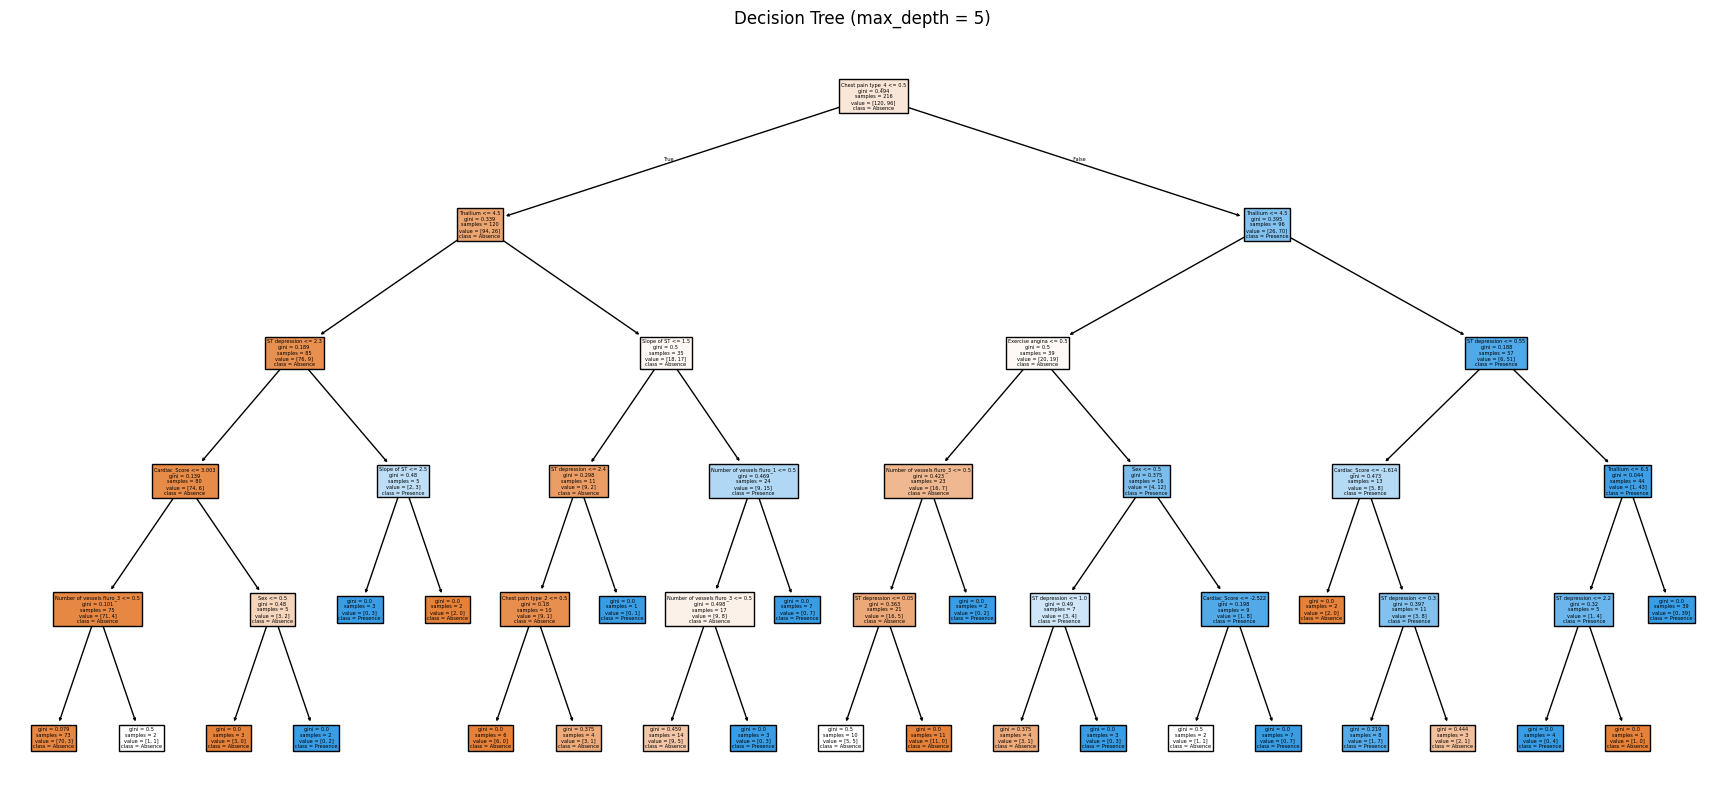

In [ ]:
plt.figure(figsize=(22, 10))
plot_tree(
    trees[5],
    feature_names=X.columns,
    class_names=['Absence', 'Presence'],
    filled=True
)
plt.title("Decision Tree (max_depth = 5)")
plt.show()

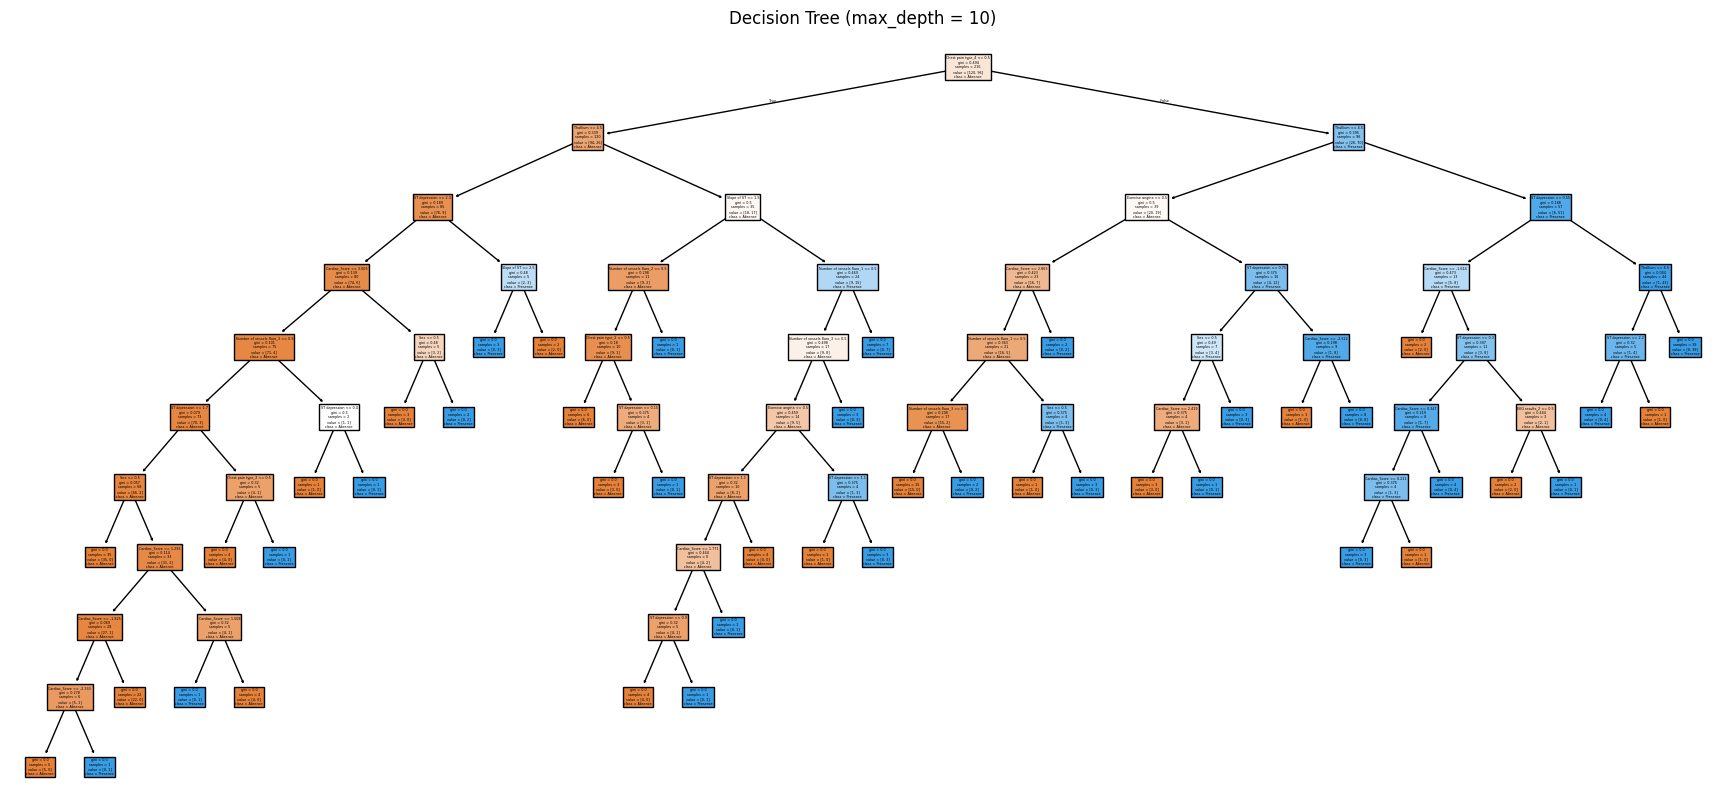

In [ ]:
plt.figure(figsize=(22, 10))
plot_tree(
    trees[10],
    feature_names=X.columns,
    class_names=['Absence', 'Presence'],
    filled=True
)
plt.title("Decision Tree (max_depth = 10)")
plt.show()

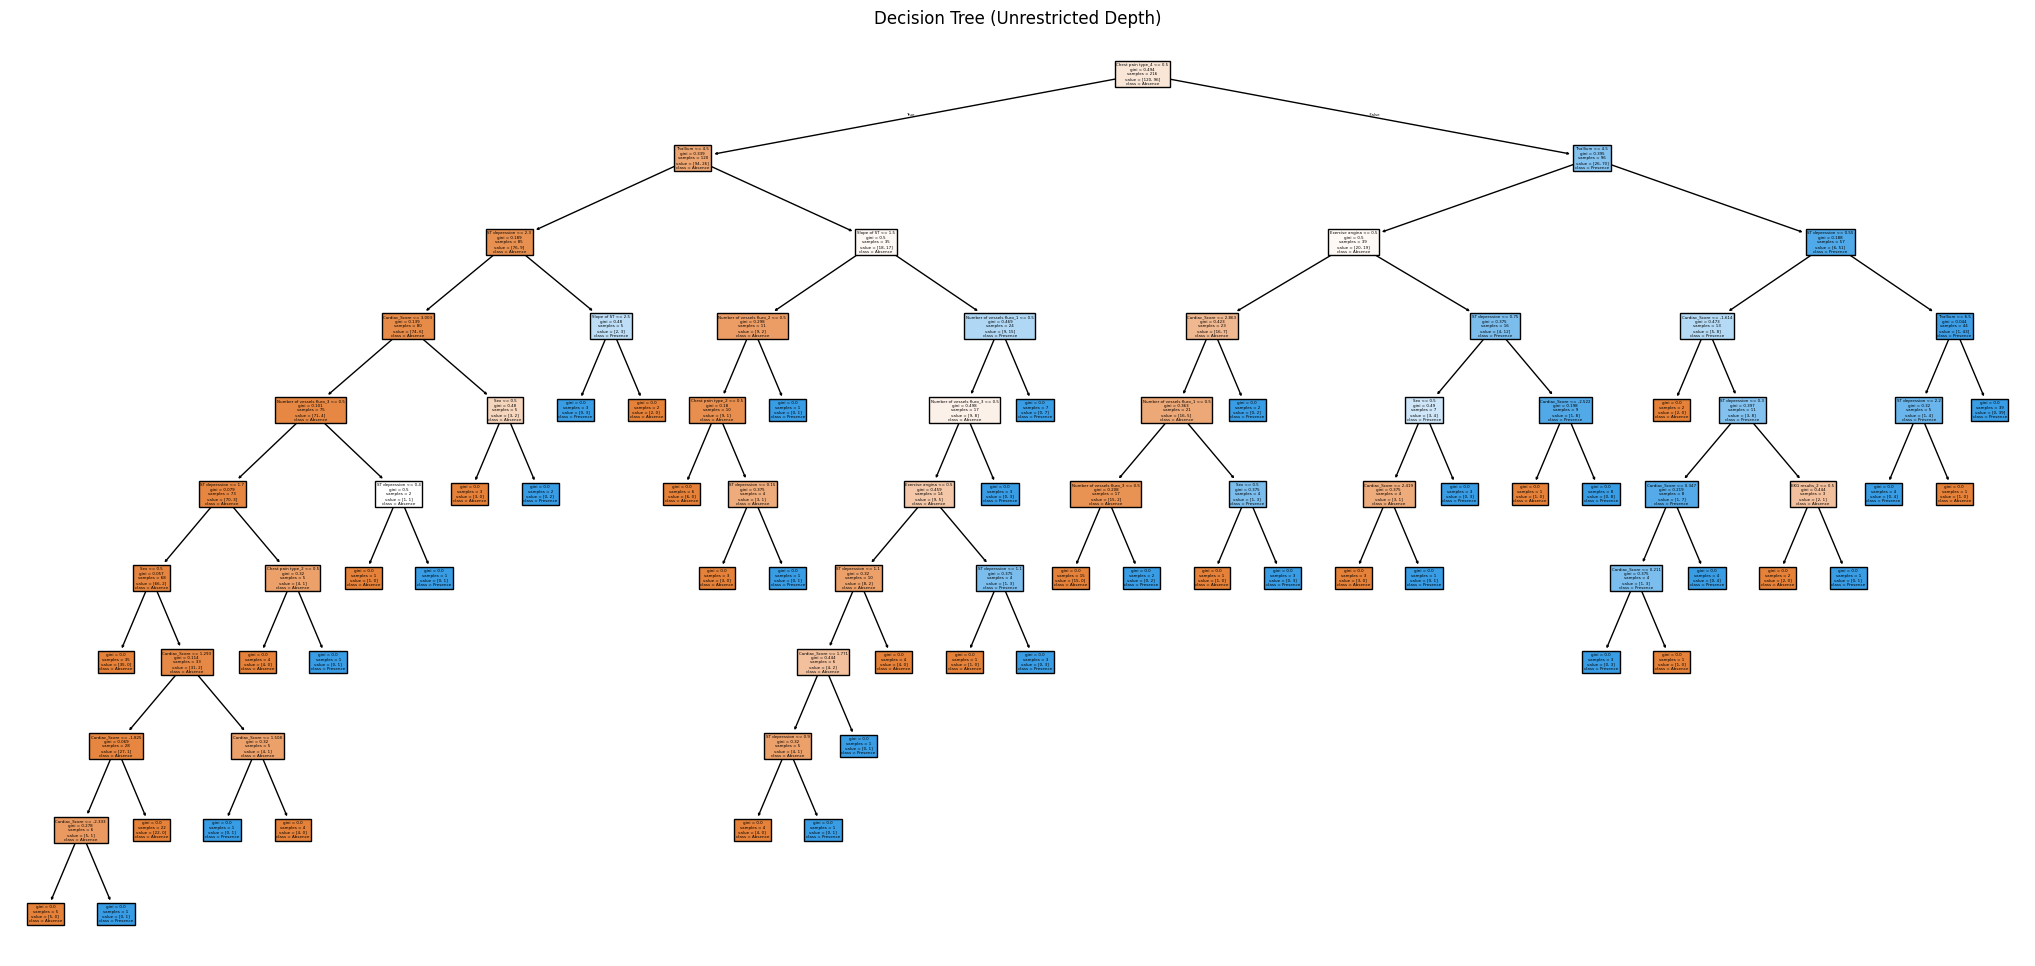

In [ ]:
plt.figure(figsize=(26, 12))
plot_tree(
    trees[None],
    feature_names=X.columns,
    class_names=['Absence', 'Presence'],
    filled=True
)
plt.title("Decision Tree (Unrestricted Depth)")
plt.show()

Visualizations of decision trees with varying maximum depths (2, 5, 10, and none) were created to examine the tradeoff between complexity, interpretability, and predictive performance. Surprisingly, the shallowest tree (depth = 2) achieved the highest precision (0.810) while maintaining strong accuracy (0.796), focusing on the most influential features such as Chest pain type and Thallium, allowing it to remain highly interpretable. Increasing the depth to 5 captured additional interactions, including ST depression, Cardiac_Score, and Number of vessels fluro, but slightly reduced precision (0.783), showing that more complexity does not always improve predictive quality. Deeper trees (depth = 10 and None) became densely branched, including splits on less important features, which lowered both accuracy and precision (0.759 and 0.720, respectively), clearly demonstrating overfitting. These results highlight that moderate or shallow depths can sometimes outperform deeper models in precision, while deeper trees can increase complexity without measurable benefit.

## Sensitivity Analysis

Sensitivity analysis is a way to see how uncertainty in a model's inputs affects its outputs. Saltelli's well-known definition describes it as determining “how variations in input parameters contribute to uncertainty in model results” (Sensitivity Analysis: The Basics). The key idea is not just changing inputs, but understanding how uncertainty moves through the model.

There are two main types of SA. Local sensitivity analysis looks at small changes around a single baseline point. It's easy to compute, but it can give misleading results when the model is nonlinear or when inputs interact. Global sensitivity analysis varies inputs across their full ranges and is generally more reliable for complex models because it captures nonlinear effects and interactions.

In decision making settings, especially decision trees, SA becomes important because the probabilities at chance nodes are often ambiguous. As Kaminski, Jakubczyk, and Szufel put it, when probabilities are uncertain in a non-stochastic way, “a need for a sensitivity analysis arises, to learn how the output of the decision making process changes when the input is varied” (A framework for sensitivity analysis of decision trees). SA helps show how stable the chosen strategy is and how much the probabilities can shift before the decision changes.

In practice, SA involves systematically varying inputs and checking how the model's outputs respond. For machine learning models like decision trees, this usually means adjusting feature values and watching how predicted classes or decision boundaries change.

$ \\ $  
Sources:  
https://uc-ebook.org/docs/html/3_sensitivity_analysis_the_basics.html  
https://pmc.ncbi.nlm.nih.gov/articles/PMC5767274/


Sensitivity analysis will be performed to measure the impact of the Thallium and ST Depression features on our decision tree's decision boundary. We will use the tree with a max_depth = 5, since it's reasonably complex, but still interpretable.

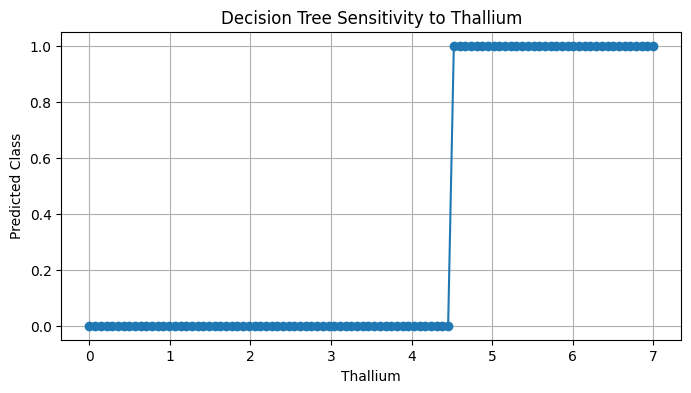

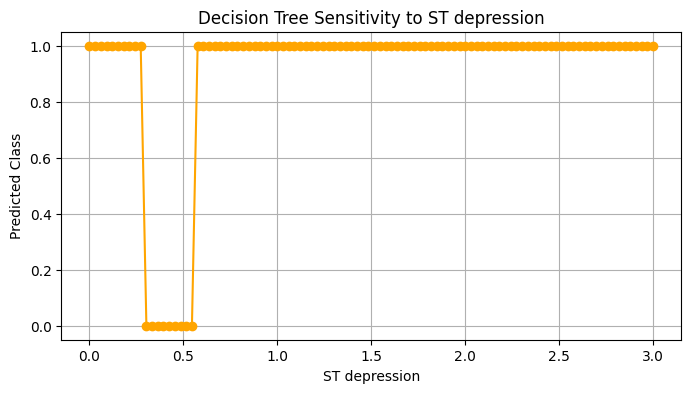

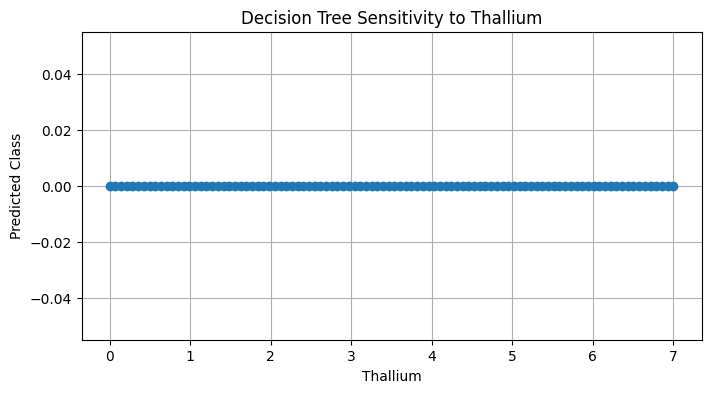

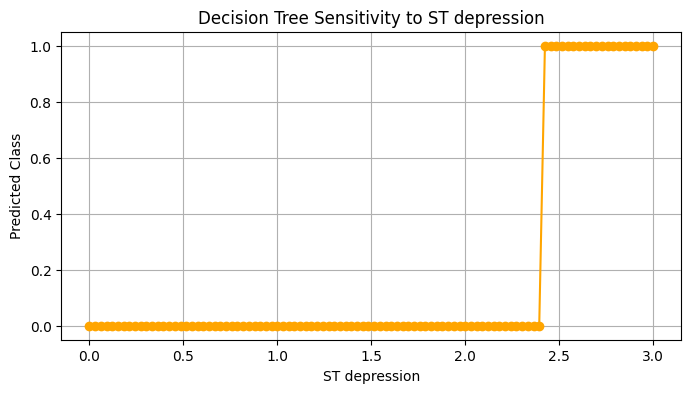

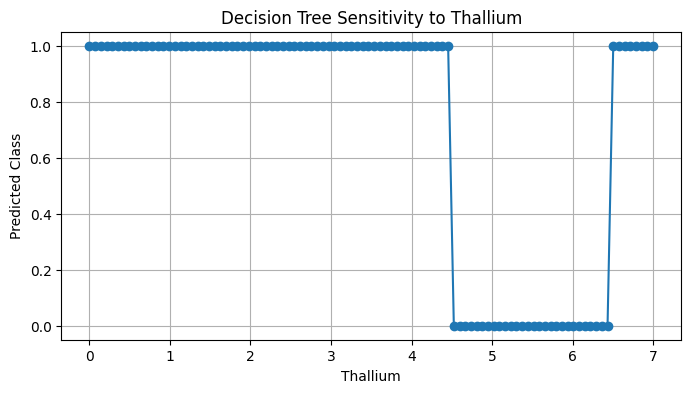

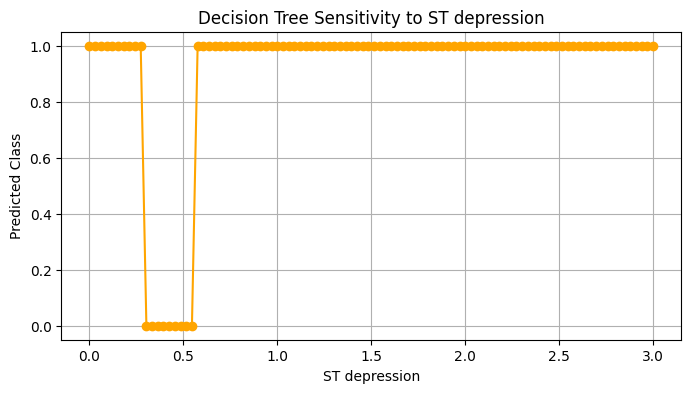

In [ ]:
# Use your trained tree (example: depth=5)
dt = trees[5]


# Pick samples from the test set
samples = [X_test.iloc[1].copy(), X_test.iloc[12].copy(), X_test.iloc[42].copy()]

for sample in samples:

    # Sensitivity for Thallium
    # Based on Thallum values, vary Thallium across the relevant splits
    thallium_range = np.linspace(0, 7, 100)

    thallium_preds = []
    for th in thallium_range:
        sample['Thallium'] = th
        pred = dt.predict(pd.DataFrame([sample]))
        thallium_preds.append(pred[0])


    plt.figure(figsize=(8,4))
    plt.plot(thallium_range, thallium_preds, marker='o')
    plt.xlabel('Thallium')
    plt.ylabel('Predicted Class')
    plt.title('Decision Tree Sensitivity to Thallium')
    plt.grid(True)
    plt.show()


    # Sensitivity for ST depression
    # Based on ST depression values, vary ST depression across the relevant splits
    st_range = np.linspace(0, 3, 100)


    st_preds = []
    for st in st_range:
        sample['ST depression'] = st
        pred = dt.predict(pd.DataFrame([sample]))
        st_preds.append(pred[0])


    plt.figure(figsize=(8,4))
    plt.plot(st_range, st_preds, marker='o', color='orange')
    plt.xlabel('ST depression')
    plt.ylabel('Predicted Class')
    plt.title('Decision Tree Sensitivity to ST depression')
    plt.grid(True)
    plt.show()

Sensitivity analysis was performed on the trained decision tree by varying two key input features, Thallium and ST depression, for three representative samples, while observing the changes in the predicted class. For Samples 1 and 3, the predicted class for Thallium remained 0 until the split threshold at approximately 4.5, where it abruptly switched to class 1, clearly reflecting the decision boundary learned by the tree. For ST depression in these same samples, the prediction was initially class 1, dropped to class 0 in the range of roughly 0.3 to 0.6, and then returned to class 1, demonstrating the stepwise behavior caused by multiple split thresholds. In contrast, Sample 2 showed no sensitivity to Thallium, with the predicted class remaining 0 across all tested values, while ST depression remained class 0 until about 2.4, where it switched to class 1. These results highlight that decision trees are insensitive to small input changes within a leaf but highly sensitive near split thresholds, where small variations in feature values can lead to abrupt changes in predictions.

## **Task 2: Bagging and Boosting Methods**

Following the implementation of our Decistion Tree Classifier, we will now implement Bagged Decision Trees (Bagging) and AdaBoost (Boosting) algorithms

Stratified k-fold cross-validation is an extension of standard k-fold cross-validation designed specifically for classification tasks, especially when the dataset is imbalanced. According to GeeksforGeeks, the key idea is that stratification “maintains the original distribution of each class across each fold,” ensuring that every fold reflects the same proportions as the full dataset. This avoids problems where random splits or regular k-fold accidentally create folds dominated by one class, which can distort evaluation metrics and lead to misleading model performance estimates. By preserving class balance in each fold, stratified k-fold produces more stable and reliable accuracy, precision, recall, and F1-score measurements.

The scikit-learn documentation describes stratified k-fold as a class-wise stratified version of k-fold that “preserves the percentage of samples for each class in y in a binary or multiclass classification setting,” making it the preferred cross-validation method for most classification models (including bagging and boosting). In practice, the algorithm repeatedly splits the data into k folds such that each fold contains the same class proportions, trains the model on k-1 folds, and evaluates it on the remaining fold. Repeating this process for multiple values of k provides a robust estimate of model generalization and helps ensure that performance differences between bagging and boosting methods are not due to chance or uneven class distributions.  
$ \\ $  
Sources:  
https://www.geeksforgeeks.org/machine-learning/stratified-k-fold-cross-validation/  
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html



When evaluating these models, we will use stratified k-fold cross-validation with threee different folds, of 5, 10 and 15. We will evaluate the models using accuracy, Precision, and F1-score.


In [ ]:
# Bagging model
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=50,
    random_state=42
)

# Boosting model (AdaBoost)
boosting_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=50,
    random_state=42
)

# Evaluate using different k-fold values
for k in [5, 10, 15]:
    cv = RepeatedStratifiedKFold(n_splits=k, n_repeats=1, random_state=42)

    # Bagging metrics
    bag_acc = cross_val_score(bagging_model, X, y,scoring='accuracy', cv=cv)
    bag_prec = cross_val_score(bagging_model, X, y, scoring='precision', cv=cv)
    bag_f1 = cross_val_score(bagging_model, X, y, scoring='f1', cv=cv)

    # Boosting metrics
    boost_acc = cross_val_score(boosting_model, X, y, scoring='accuracy', cv=cv)
    boost_prec = cross_val_score(boosting_model, X, y, scoring='precision', cv=cv)
    boost_f1 = cross_val_score(boosting_model, X, y, scoring='f1', cv=cv)

    print(f"\n{k}-Fold Stratified CV")
    print("Bagging  - Acc: %.3f  Prec: %.3f  F1: %.3f"
          % (mean(bag_acc), mean(bag_prec), mean(bag_f1)))
    print("Boosting - Acc: %.3f  Prec: %.3f  F1: %.3f"
          % (mean(boost_acc), mean(boost_prec), mean(boost_f1)))


5-Fold Stratified CV
Bagging  - Acc: 0.781  Prec: 0.766  F1: 0.746
Boosting - Acc: 0.793  Prec: 0.762  F1: 0.774

10-Fold Stratified CV
Bagging  - Acc: 0.774  Prec: 0.783  F1: 0.733
Boosting - Acc: 0.759  Prec: 0.731  F1: 0.741

15-Fold Stratified CV
Bagging  - Acc: 0.793  Prec: 0.820  F1: 0.746
Boosting - Acc: 0.733  Prec: 0.710  F1: 0.699


## Behavior of Bagging vs. Boosting Under Different Metrics

Across all cross-validation settings, Bagging and Boosting exhibit distinct performance characteristics depending on the evaluation metric. Boosting generally achieves slightly higher accuracy and F1-score in the 5-fold setting, suggesting that AdaBoost benefits from focusing on hard-to-classify samples when the training sets are relatively large. However, as the number of folds increases to 10 and 15, Bagging consistently outperforms Boosting in accuracy and precision, with especially strong gains in precision at 15 folds (0.820 vs. 0.710). This indicates that Bagging produces more stable and reliable positive predictions as the training data per fold becomes smaller.

The performance ranking does change depending on the metric used. For example, in 10-fold cross-validation, Bagging has higher accuracy and precision, while Boosting slightly edges out Bagging in F1-score. This occurs because precision, recall, and F1 capture different aspects of model behavior. Boosting tends to improve recall by aggressively correcting misclassified points, which can raise F1-score but also increase false positives, lowering precision. In contrast, Bagging reduces variance by averaging many independent trees, leading to more conservative predictions and higher precision.

Overall, these results show that no single ensemble method is uniformly superior. Rather, the preferred model depends on the evaluation metric and the desired trade-off between precision and recall. Bagging is more robust and stable across folds, while Boosting can achieve stronger performance on balanced metrics like F1 when overfitting is controlled.

### **Task 3: Comparing Effectiveness of Models**

To compare the effectiveness of the vanilla Decision Tree Classifier, as well as the Bagging and AdaBoost algorithms, we will use a confusion matrix for one selected test fold with k=5. We will also use a paired t-test to determine if the differences between models are significant.

### Confusion Matrices

We use confusion matrices to compare effectiveness of all three models for one selected test fold of k=5.

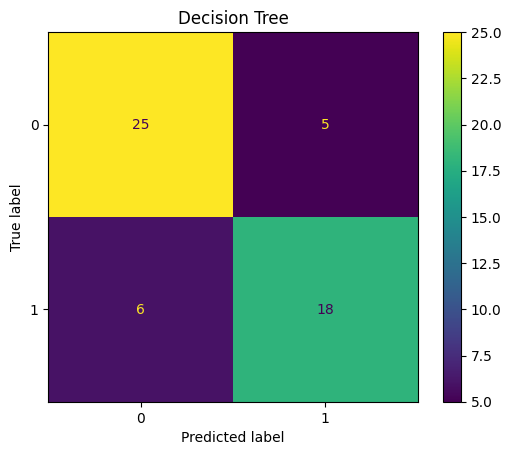

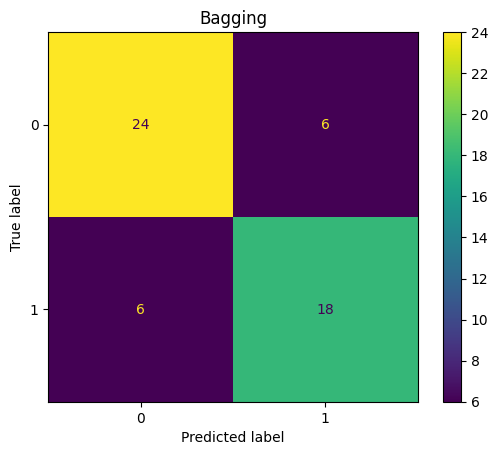

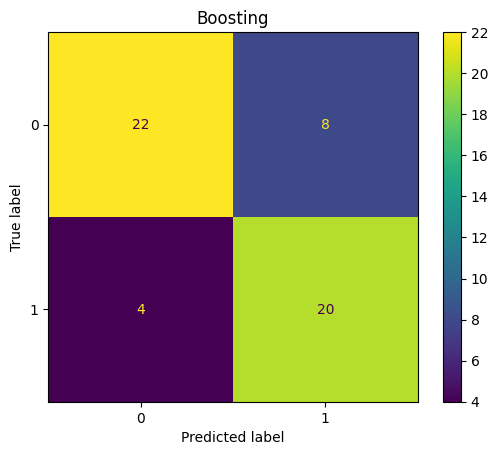

In [ ]:
# Redefine models
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=50,
    random_state=42
)
boosting_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=50,
    random_state=42
)

models = {
    "Decision Tree": dt_model,
    "Bagging": bagging_model,
    "Boosting": boosting_model
}

# Use one fold from stratified CV
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_x, test_x = next(sk.split(X, y))

X_train, X_test = X.iloc[train_x], X.iloc[test_x]
y_train, y_test = y.iloc[train_x], y.iloc[test_x]

# Plot confusion matrices
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)

    disp.plot()
    plt.title(name)
    plt.show()

The confusion matrices show how each model classifies negative (0) and positive (1) cases. The Decision Tree achieved 25 true negatives, 5 false positives, 18 true positives, and 6 false negatives, slightly favoring correct negative predictions but misclassifying some positives. Bagging produced a similar pattern with 24 true negatives, 6 false positives, 18 true positives, and 6 false negatives. Bagging reduces variance, making predictions more stable across folds, although there is a minor increase in false positives compared to the single tree.

Boosting shows a different behavior. It correctly identifies more positive cases with 20 true positives and only 4 false negatives, but at the cost of increasing false positives to 8 and reducing true negatives to 22. This matches Boosting's tendency to focus on hard-to-classify cases, improving recall at the expense of precision. Overall, the three models illustrate the trade-off between identifying positives and avoiding false positives, with Boosting prioritizing positive detection, Bagging stabilizing predictions, and the single decision tree balancing the two.

### Paired T-Test

We now evaluate the statistical significance of differences between the models. By computing accuracy, precision, and F1-score for each model across all folds of a 5-fold Stratified Cross-Validation, we obtain multiple observations per model. This allows us to perform paired t-tests, which compare the distributions of metrics between pairs of models. These tests indicate whether observed differences are likely due to random chance or reflect real differences in model performance.

In [ ]:
# Initialize arrays to store metric scores for all folds
dt_acc, dt_prec, dt_f1 = [], [], []
bag_acc, bag_prec, bag_f1 = [], [], []
boost_acc, boost_prec, boost_f1 = [], [], []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_x, test_x in skf.split(X, y):
    X_train, X_test = X.iloc[train_x], X.iloc[test_x]
    y_train, y_test = y.iloc[train_x], y.iloc[test_x]

    # Decision Tree
    dt_model.fit(X_train, y_train)
    y_pred = dt_model.predict(X_test)
    dt_acc.append(accuracy_score(y_test, y_pred))
    dt_prec.append(precision_score(y_test, y_pred))
    dt_f1.append(f1_score(y_test, y_pred))

    # Bagging
    bagging_model.fit(X_train, y_train)
    y_pred = bagging_model.predict(X_test)
    bag_acc.append(accuracy_score(y_test, y_pred))
    bag_prec.append(precision_score(y_test, y_pred))
    bag_f1.append(f1_score(y_test, y_pred))

    # Boosting
    boosting_model.fit(X_train, y_train)
    y_pred = boosting_model.predict(X_test)
    boost_acc.append(accuracy_score(y_test, y_pred))
    boost_prec.append(precision_score(y_test, y_pred))
    boost_f1.append(f1_score(y_test, y_pred))


# Function to run paired t-test and print
def paired_ttest(scores1, scores2, name1, name2, metric):
    t_stat, p_val = ttest_rel(scores1, scores2)
    print(f"{metric} - {name1} vs {name2}: t = {t_stat:.3f}, p = {p_val:.3f}")

# Accuracy
paired_ttest(dt_acc, bag_acc, "Decision Tree", "Bagging", "Accuracy")
paired_ttest(dt_acc, boost_acc, "Decision Tree", "Boosting", "Accuracy")
paired_ttest(bag_acc, boost_acc, "Bagging", "Boosting", "Accuracy")

# Precision
paired_ttest(dt_prec, bag_prec, "Decision Tree", "Bagging", "Precision")
paired_ttest(dt_prec, boost_prec, "Decision Tree", "Boosting", "Precision")
paired_ttest(bag_prec, boost_prec, "Bagging", "Boosting", "Precision")

# F1-score
paired_ttest(dt_f1, bag_f1, "Decision Tree", "Bagging", "F1-score")
paired_ttest(dt_f1, boost_f1, "Decision Tree", "Boosting", "F1-score")
paired_ttest(bag_f1, boost_f1, "Bagging", "Boosting", "F1-score")

Accuracy - Decision Tree vs Bagging: t = -0.000, p = 1.000
Accuracy - Decision Tree vs Boosting: t = -0.535, p = 0.621
Accuracy - Bagging vs Boosting: t = -0.739, p = 0.501
Precision - Decision Tree vs Bagging: t = -0.066, p = 0.951
Precision - Decision Tree vs Boosting: t = 0.051, p = 0.961
Precision - Bagging vs Boosting: t = 0.139, p = 0.896
F1-score - Decision Tree vs Bagging: t = -0.227, p = 0.831
F1-score - Decision Tree vs Boosting: t = -1.624, p = 0.180
F1-score - Bagging vs Boosting: t = -2.489, p = 0.068


The results show that none of the differences are statistically significant at the standard p = 0.05 level. For example, the t-test comparing Decision Tree and Boosting accuracy gives t = -0.535, p = 0.621, indicating that the observed difference could easily occur by chance. Similarly, differences in precision and F1-score between all pairs of models also have high p-values, suggesting no strong evidence that one model consistently outperforms another across folds.

The largest observed difference is in the F1-score between Bagging and Boosting (t = -2.489, p = 0.068), which approaches significance but still does not meet the p = 0.05 threshold. Overall, these results indicate that while the models show some differences in confusion matrices and individual folds, their overall performance is statistically similar, supporting the idea that ensemble methods stabilize performance but may not always produce large improvements over a well-tuned single decision tree on this dataset.

## Bias Variance Trade-Off

The single Decision Tree exhibits a moderate balance between bias and variance. It is flexible enough to capture nonlinear relationships in the data, which keeps bias relatively low, but it is also sensitive to variations in the training set. This sensitivity leads to occasional misclassifications of both positive and negative cases, as reflected in the confusion matrix. In other words, while it can model complex patterns, the predictions can fluctuate depending on which examples appear in the training fold.

Bagging addresses this by reducing variance. By averaging predictions across multiple independently trained trees, Bagging stabilizes the outputs, making the model less dependent on any single training split. This explains why the Bagging model produces similar confusion matrix results to the single tree but with slightly fewer extreme fluctuations across folds. The bias remains similar to a single tree, but the overall predictive performance is more consistent, which aligns with the principle that Bagging is designed to lower variance without significantly changing bias.

Boosting, in contrast, primarily works to reduce bias by sequentially focusing on examples that previous trees misclassified. This allows the model to better capture difficult patterns in the data, improving its ability to correctly identify positive cases and reduce false negatives. However, because it pays extra attention to hard to classify samples, the model becomes slightly more sensitive to noise, which can increase variance, as seen in the occasional rise in false positives.

Overall, these three models illustrate the bias variance trade-off. The Decision Tree balances the two, Bagging reduces variance to improve stability, and Boosting reduces bias to better capture challenging patterns, demonstrating how ensemble methods can be tailored to emphasize either stability or predictive accuracy.